In [2]:
# Packages

import numpy as np
import pandas as pd
from pandas import Series
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from chart_studio.plotly import plot_mpl
import warnings
warnings.filterwarnings("ignore")

# SKLearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report

#Plotly
from plotly.offline import plot 
import plotly
import plotly.graph_objs as go
import plotly.offline as pyoff
plotly.offline.init_notebook_mode(connected=True)

from pmdarima.arima import auto_arima
from math import sqrt
from pylab import rcParams
import statsmodels.api as sm

# Statsmodel
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

#Keras
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from tensorflow.keras.layers import LSTM

Using TensorFlow backend.


In [3]:
# Import data
ds = pd.read_csv('train.csv', parse_dates = ['Date'], low_memory = False)
ds.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


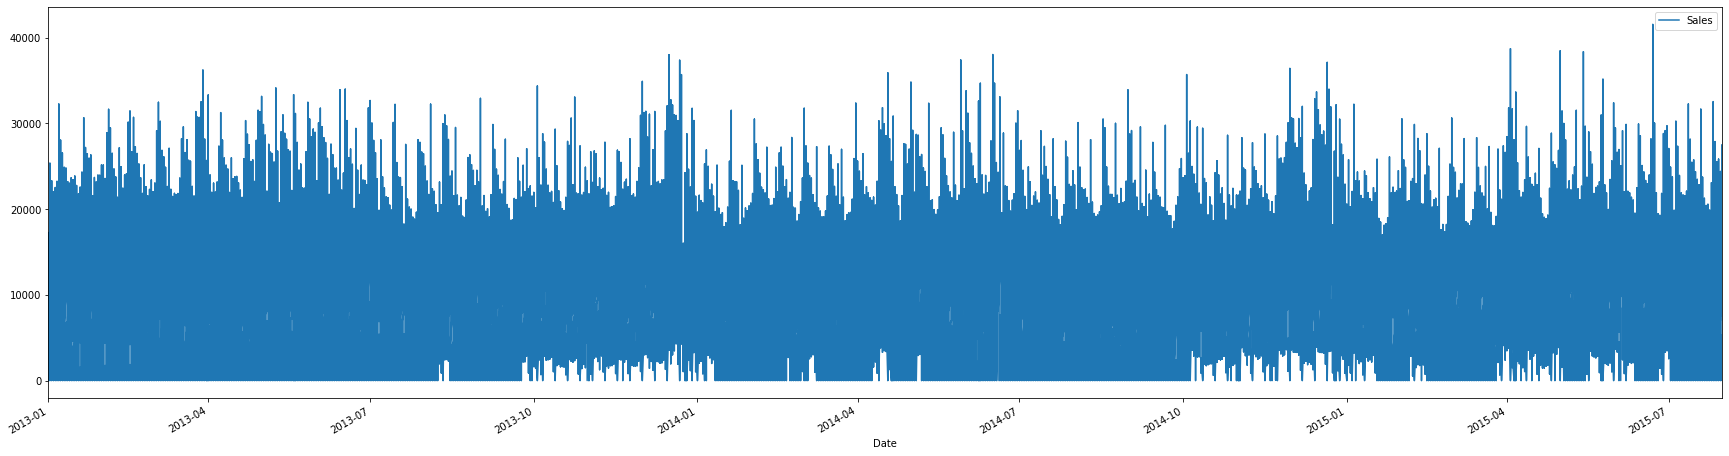

In [4]:
# Visualize data
ds[['Date','Sales']].plot('Date', figsize=(30,8))
# consistent trend with seasonal variations
# The seasonality suggests that the series is almost certainly non-stationary.

In [5]:
# Date range for data
ds['Date'].min(), ds['Date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [6]:
# Data type of each column. 
ds.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [7]:
# Count unique values of each column
def count_unique(column):
    return len(column.unique())

ds.apply(count_unique, axis=0).astype(np.int64)

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64

In [8]:
# Does any column have missing values?
ds.isnull().any()

Store            False
DayOfWeek        False
Date             False
Sales            False
Customers        False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

In [9]:
# Number of records
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [10]:
# Data Exploration

df = pd.read_csv('train.csv', parse_dates = ['Date'], low_memory = False)

df.set_index('Date', inplace = True)

# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.weekday_name

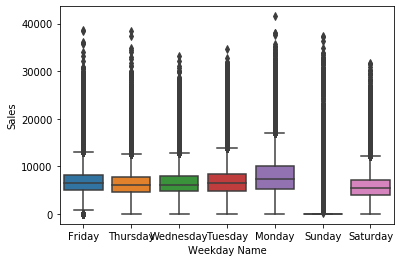

In [11]:
#let’s group the time series by day of the week, to explore weekly seasonality.
sns.boxplot(data=df, x='Weekday Name', y='Sales'); #Closed on Sunday!

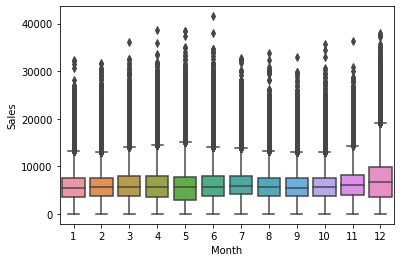

In [12]:
#let’s group the time series by month.
sns.boxplot(data=df, x='Month', y='Sales'); 

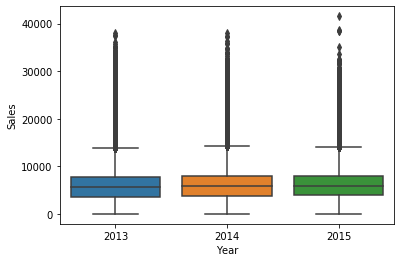

In [13]:
#let’s group the time series by year.
sns.boxplot(data=df, x='Year', y='Sales'); 

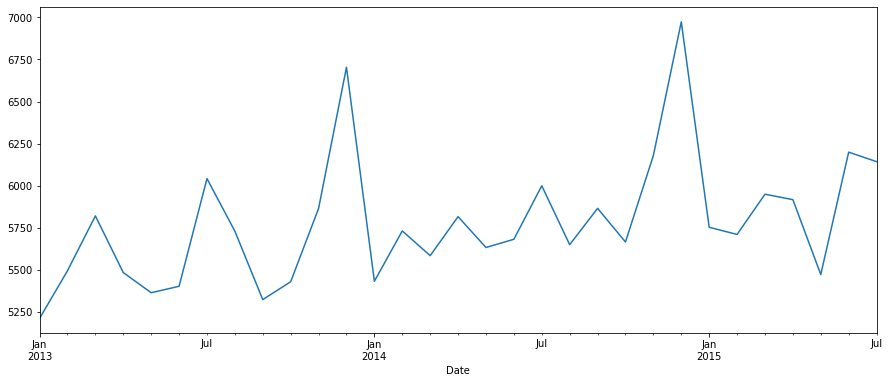

In [14]:
# Monthly Sales
y = df['Sales'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

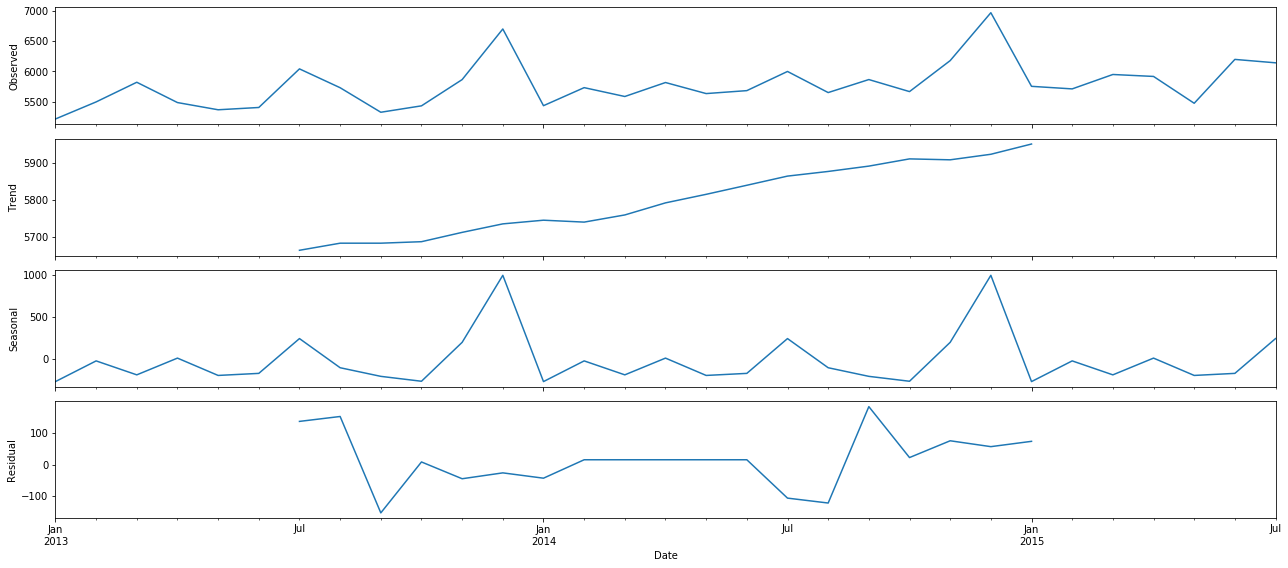

In [15]:
# Decomposition

rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [16]:
#Dealing with State Holiday
ds.StateHoliday.unique() #list all different values of the column

array(['0', 'a', 'b', 'c'], dtype=object)

In [17]:
# StateHoliday has 0 as an integer and string, so convert whole column to string values.
ds.StateHoliday = ds.StateHoliday.astype(str)

#Replace values in columns with actual categorical values
ds['StateHoliday'].replace(['0','a','b','c'],
                           ['None','Public','Easter','Christmas'],
                           inplace=True)

# One Hot Encoding
ds = pd.get_dummies(ds, columns=["StateHoliday"], prefix=["StateHoliday"])

In [18]:
# Updated dataframe
ds.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public
0,1,5,2015-07-31,5263,555,1,1,1,0,0,1,0
1,2,5,2015-07-31,6064,625,1,1,1,0,0,1,0
2,3,5,2015-07-31,8314,821,1,1,1,0,0,1,0
3,4,5,2015-07-31,13995,1498,1,1,1,0,0,1,0
4,5,5,2015-07-31,4822,559,1,1,1,0,0,1,0


In [19]:
# Numerical predictors
numeric_features = ds.select_dtypes(include=[np.number])
numeric_features.dtypes

Store                     int64
DayOfWeek                 int64
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
SchoolHoliday             int64
StateHoliday_Christmas    uint8
StateHoliday_Easter       uint8
StateHoliday_None         uint8
StateHoliday_Public       uint8
dtype: object

In [20]:
# Correlation between Numerical Predictors and Target variable
corr = numeric_features.corr()
print(corr['Sales'].sort_values(ascending = False))

# the most positive correlation belongs to Customers (more customers = higher sale)
# Date related fields have lowest correlation with our target variable (holidays = less sales)

Sales                     1.000000
Customers                 0.894711
Open                      0.678472
Promo                     0.452345
StateHoliday_None         0.254216
SchoolHoliday             0.085124
Store                     0.005126
StateHoliday_Christmas   -0.092618
StateHoliday_Easter      -0.117497
StateHoliday_Public      -0.203028
DayOfWeek                -0.462125
Name: Sales, dtype: float64


In [21]:
# Make series stationary by aggregating dataset at weekly basis
ds.index = pd.to_datetime(ds['Date'])
dtsales = ds.resample('W').Sales.sum().reset_index()
#Limits trend by taking average for a time period like monthly/weekly averages

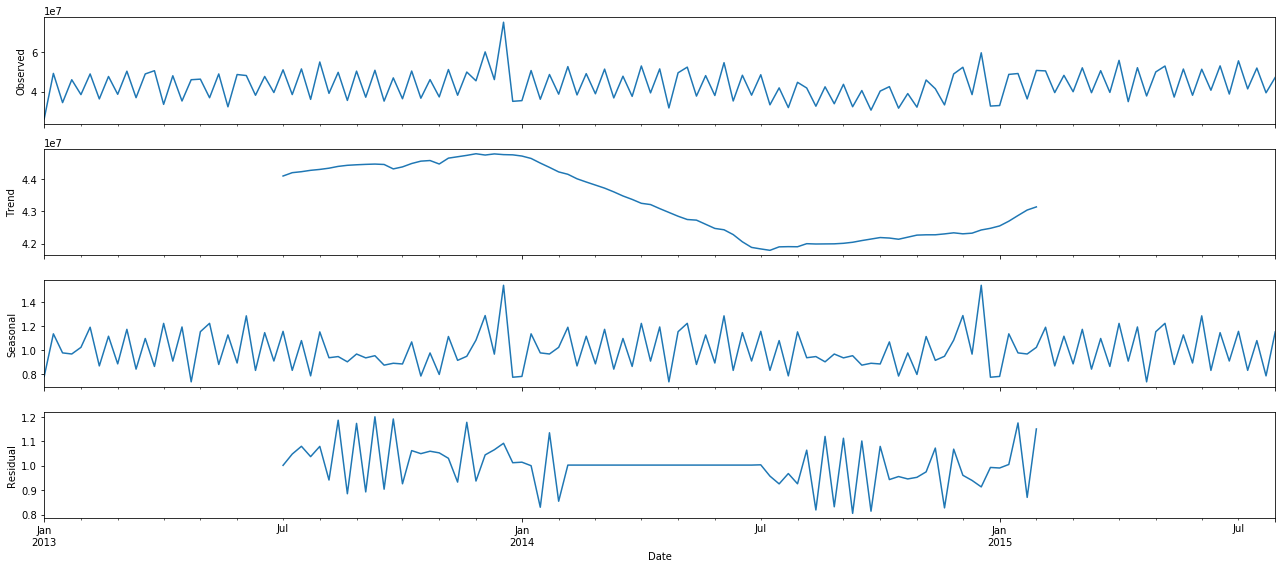

In [22]:
# Decomposition
dtsales2 = dtsales
dtsales2['Date'] = pd.to_datetime(dtsales2['Date'])
dtsales2 = dtsales2.set_index('Date')
result = seasonal_decompose(dtsales2, model='multiplicative')
result.plot()
plt.show()
# clearly see the seasonal component of the data

In [23]:
# Aggregated data
dtsales

,Date,Sales
0,2013-01-06,26129335
1,2013-01-13,49275222
2,2013-01-20,34377765
3,2013-01-27,46040169
4,2013-02-03,38466029
...,...,...
130,2015-07-05,55690481
131,2015-07-12,41391282
132,2015-07-19,52008419
133,2015-07-26,39402115


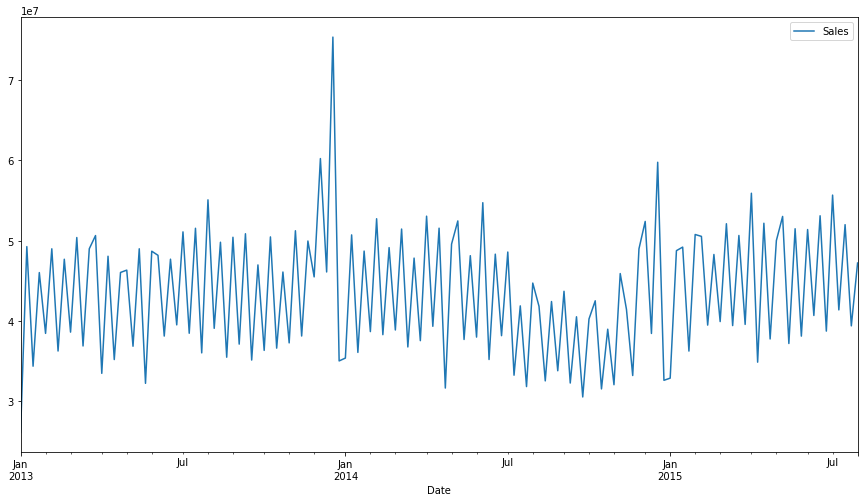

In [24]:
# Visualizing aggregated data
dtsales[['Date','Sales']].plot('Date', figsize=(15,8))
# do not appear to be any obvious outliers.
# huge spikes in December
# The seasonality suggests that the series is almost certainly non-stationary.

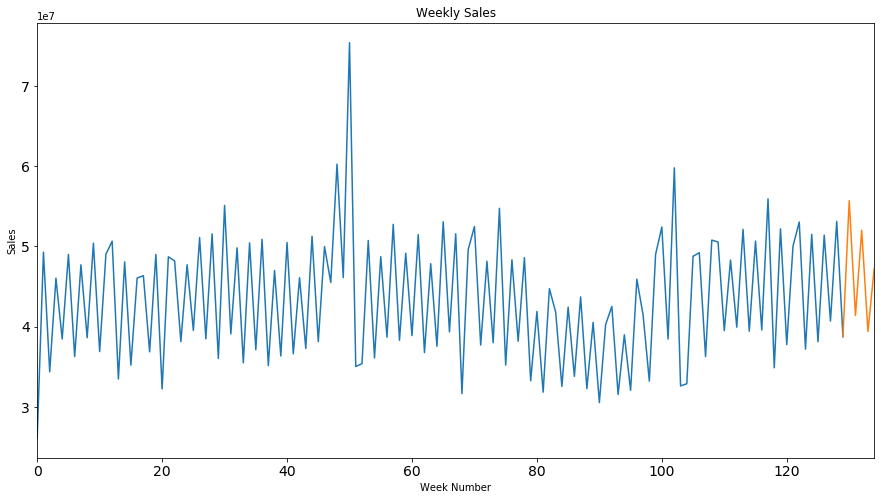

In [25]:
# Visualizing train and test (6 weeks)
train = dtsales[0:-5] 
test = dtsales[-6:]
# The first 128 weeks (August 2012 – October 2013) are used as training data 
# next 6 weeks (June 2015 – August 2015) as testing data.

train.Sales.plot(figsize=(15,8), title= 'Weekly Sales', fontsize=14)
test.Sales.plot(figsize=(15,8), title= 'Weekly Sales', fontsize=14)
plt.xlabel('Week Number')
plt.ylabel('Sales')
plt.show()
# do not appear to be any obvious outliers.
# huge spikes in December

In [26]:
#LSTM MODEL

# Create a new dataframe to model the difference
dtdiff = dtsales.copy()

# Add previous sales to the next row
dtdiff['prevsales'] = dtdiff['Sales'].shift(1)

# Drop the null values and calculate the difference
dtdiff = dtdiff.dropna()
dtdiff['diff'] = (dtdiff['Sales'] - dtdiff['prevsales'])

# Create dataframe for transformation from time series to supervised
dtsupervised = dtdiff.drop(['prevsales'],axis=1)

# look-back period = 52 weeks (1 calander year)

# Adding lags
for inc in range(1,53):
    field_name = 'lag_' + str(inc)
    dtsupervised[field_name] = dtsupervised['diff'].shift(inc)

# Drop null values
dtsupervised = dtsupervised.dropna().reset_index(drop=True)

# How useful are our features for prediction?

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=dtsupervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(f'lag_1 explains {regression_adj_rsq:.3f} of the variation.')

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12 + lag_13 + lag_14 + lag_15 + lag_16 + lag_17 + lag_18 + lag_19 + lag_20 + lag_21 + lag_22 + lag_23 + lag_24 + lag_25 + lag_26 + lag_27 + lag_28 + lag_29 + lag_30 + lag_31 + lag_32 + lag_33 + lag_34 + lag_35 + lag_36 + lag_37 + lag_38 + lag_39 + lag_40 + lag_41 + lag_42 + lag_43 + lag_44 + lag_45 + lag_46 + lag_47 + lag_48 + lag_49 + lag_50 + lag_51 + lag_52', data=dtsupervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(f'Entire feature set explains {regression_adj_rsq:.3f} of the variation.')

# Create a new dataframe for LSTM model
dfmodel = dtsupervised.drop(['Sales','Date'],axis=1)

# As the test set, we have selected the last 6 weeks’ sales.
train_set, test_set = dfmodel[0:-6].values, dfmodel[-6:].values

# Apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

# Reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# Reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

# Create feature and label sets from scaled datasets
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Fit LSTM model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

y_pred = model.predict(X_test,batch_size=1)

# Inverse transformation for scaling

# Reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

# Rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

# Reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

# Inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

# Create dataframe that shows the predicted sales
resultlist = []
salesdates = list(dtsales[-7:].Date)
actsales = list(dtsales[-7:].Sales)
for index in range(0,len(pred_test_set_inverted)):
    resultdict = {}
    resultdict['Date'] = salesdates[index+1]
    resultdict['PredictedValue'] = int(pred_test_set_inverted[index][0] + actsales[index])
    resultlist.append(resultdict)
dtresult = pd.DataFrame(resultlist)

# Merge with actual sales dataframe
dtsalespred = pd.merge(dtsales, dtresult, on='Date', how='left')

# Plot actual and predicted
plot_data = [
    go.Scatter(
        x=dtsalespred['Date'],
        y=dtsalespred['Sales'],
        name='actual'
    ),
        go.Scatter(
        x=dtsalespred['Date'],
        y=dtsalespred['PredictedValue'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# LMSE Accuracy
trueandpred = dtsalespred.tail(6)
y_true = trueandpred["Sales"].tolist()
y_pred = trueandpred["PredictedValue"].tolist()
rms = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f'RMSLE of the LSTM model is: {rms}.')

lag_1 explains 0.657 of the variation.
Entire feature set explains 0.825 of the variation.
Train on 76 samples
Epoch 1/100
76/76 [==============================] - 16s 209ms/sample - loss: 0.2453 - loss: 0.
Epoch 2/100
76/76 [==============================] - 1s 14ms/sample - loss: 0.1924
Epoch 3/100
76/76 [==============================] - 1s 13ms/sample - loss: 0.1491
Epoch 4/100
76/76 [==============================] - 1s 11ms/sample - loss: 0.11190s - loss: 0
Epoch 5/100
76/76 [==============================] - 1s 13ms/sample - loss: 0.0845
Epoch 6/100
76/76 [==============================] - 1s 10ms/sample - loss: 0.06760s - los
Epoch 7/100
76/76 [==============================] - 1s 11ms/sample - loss: 0.0579
Epoch 8/100
76/76 [==============================] - 1s 11ms/sample - loss: 0.0517
Epoch 9/100
76/76 [==============================] - ETA: 0s - loss: 0.048 - 1s 11ms/sample - loss: 0.0470
Epoch 10/100
76/76 [==============================] - 1s 10ms/sample - loss: 0.04310s

76/76 [==============================] - 1s 13ms/sample - loss: 2.3789e-04
Epoch 89/100
76/76 [==============================] - 1s 15ms/sample - loss: 1.4518e-04
Epoch 90/100
76/76 [==============================] - 1s 14ms/sample - loss: 7.5792e-05
Epoch 91/100
76/76 [==============================] - 1s 14ms/sample - loss: 1.4759e-040s - loss: 1.
Epoch 92/100
76/76 [==============================] - 1s 11ms/sample - loss: 1.5010e-040s - loss
Epoch 93/100
76/76 [==============================] - 1s 14ms/sample - loss: 1.2879e-04
Epoch 94/100
76/76 [==============================] - 1s 17ms/sample - loss: 1.2998e-040s - loss: 1.2629e
Epoch 95/100
76/76 [==============================] - 1s 15ms/sample - loss: 1.0697e-04
Epoch 96/100
76/76 [==============================] - 2s 21ms/sample - loss: 1.3817e-04
Epoch 97/100
76/76 [==============================] - 1s 15ms/sample - loss: 1.9645e-04
Epoch 98/100
76/76 [==============================] - 1s 17ms/sample - loss: 2.3791e-04
Epoch

RMSLE of the LSTM model is: 0.06073988021274094.


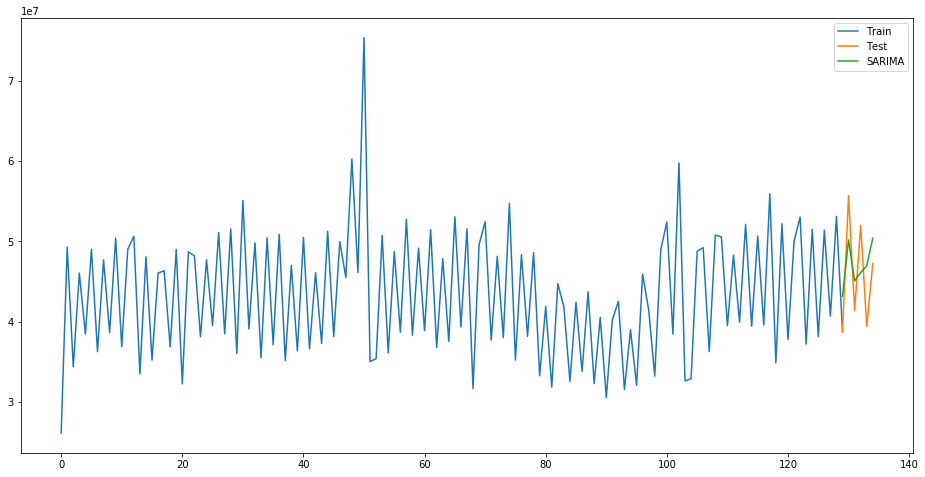

RMSLE of the SARIMA model is: 0.11499736937464207.


In [29]:
# SARIMA
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Sales, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start=129, end=134, dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

# SARIMA Accuracy
rms = sqrt(mean_squared_log_error(test.Sales, y_hat_avg.SARIMA))
print(f'RMSLE of the SARIMA model is: {rms}.')

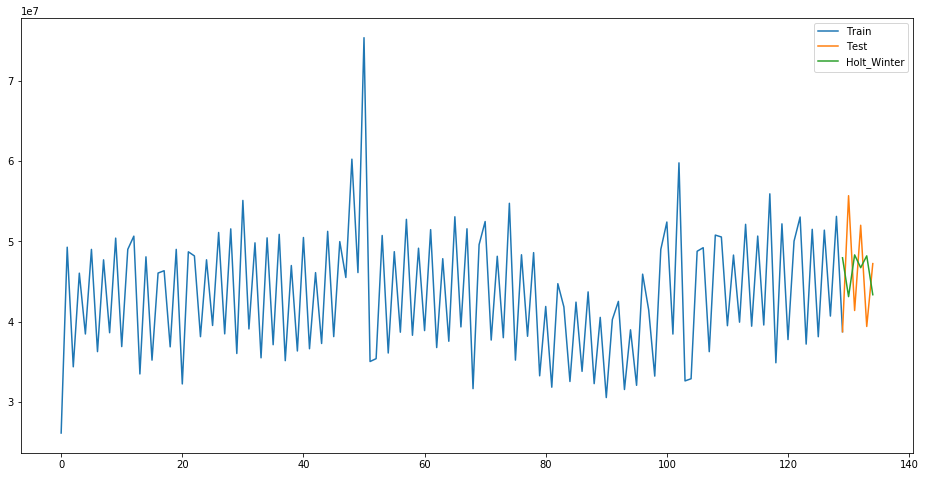

RMSLE of the Holt-Winters model is: 0.1799357870178329.


In [28]:
# Holt-Winters Method
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=4 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

# Holt-Winters Method Accuracy
rms = sqrt(mean_squared_log_error(test.Sales, y_hat_avg.Holt_Winter))
print(f'RMSLE of the Holt-Winters model is: {rms}.')